In [4]:
from cycle_ratio import CycleRatio, read_graph
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import networkx as nx
from tqdm import tqdm
import json
import random
from matplotlib.backends.backend_pdf import PdfPages


cycle_ratio = {}
degree_ratio = {}
coreness_ratio = {}
h_index_ratio = {}
random_ratio = {}

indices_performance = {'sum': {}, 'mul': {}}

datasets = ['Celegans.txt', 'Email.txt', 'Jazz.txt', 'NS_GC.txt', 'USAir.txt', 'Yeast.txt']

In [5]:
def hindex(g, n):
    sorted_neighbor_degrees = sorted(
        (g.degree(v) for v in g.neighbors(n)), reverse=True)
    h = 0
    for i in range(1, len(sorted_neighbor_degrees)+1):
        if sorted_neighbor_degrees[i-1] < i:
            break
        h = i
    return h


def edge_importance_sorter(node_ratio: list, method: str):
    if method == 'sum':
        node_ratio = sorted(node_ratio, key=lambda x: x[2], reverse=True)
    elif method == 'mul':
        node_ratio = sorted(node_ratio, key=lambda x: x[3], reverse=True)
    else:
        raise ValueError(f"Supported methods are 'sum' and 'mul' not {method}")
    return [(left, right) for left, right, _, _ in node_ratio]


def edge_importance_calculator(graph: nx.Graph, node_ratio: dict):
    edge_perculation_ratio = []
    for left, right in graph.edges():
        ap1 = node_ratio[left] + node_ratio[right]
        ap2 = node_ratio[left] * node_ratio[right]
        edge_perculation_ratio.append(
            (left, right, ap1, ap2)
        )
    return edge_perculation_ratio


def edge_perculation(graph: nx.Graph, sorted_edges: list):
    pointer = 0
    N = graph.number_of_nodes()
    connected_components = list(nx.connected_components(graph))
    largest_component = max(connected_components, key=len)
    sub_graph = graph.subgraph(largest_component)
    g_n_track = [sub_graph.number_of_nodes()]

    with tqdm(total=len(sorted_edges)) as pbar:
        while pointer < len(sorted_edges):
            graph.remove_edge(*sorted_edges[pointer])
            connected_components = list(nx.connected_components(graph))
            if len(connected_components) > 0:
                largest_component = max(connected_components, key=len)
                sub_graph = graph.subgraph(largest_component)
                g_n_track.append(
                    sub_graph.number_of_nodes()
                )
            else:
                g_n_track.append(0)
            pointer += 1
            pbar.update(1)

    return [(g_n/N) for g_n in g_n_track]


def plot_perculation(g: list, color: str, facecolors: str, label: str):
    SKIP = int(len(g)*0.01)
    Y = g[::max(SKIP, 1)]
    X = np.arange(len(Y))/len(Y)
    plt.plot(X, Y, linestyle='-', color=color, zorder=1)
    plt.scatter(X, Y, marker='o', edgecolors=color, facecolors=facecolors, zorder=2, label=label)

Processing Celegans network


100%|██████████| 2148/2148 [00:00<00:00, 3484.37it/s]


Processing Email network


100%|██████████| 5451/5451 [00:04<00:00, 1144.99it/s]


Processing Jazz network


100%|██████████| 2742/2742 [00:00<00:00, 6076.30it/s]


Processing NS_GC network


100%|██████████| 914/914 [00:00<00:00, 4302.02it/s]


Processing USAir network


100%|██████████| 2126/2126 [00:00<00:00, 4406.87it/s]


Processing Yeast network


100%|██████████| 11693/11693 [00:29<00:00, 402.27it/s]


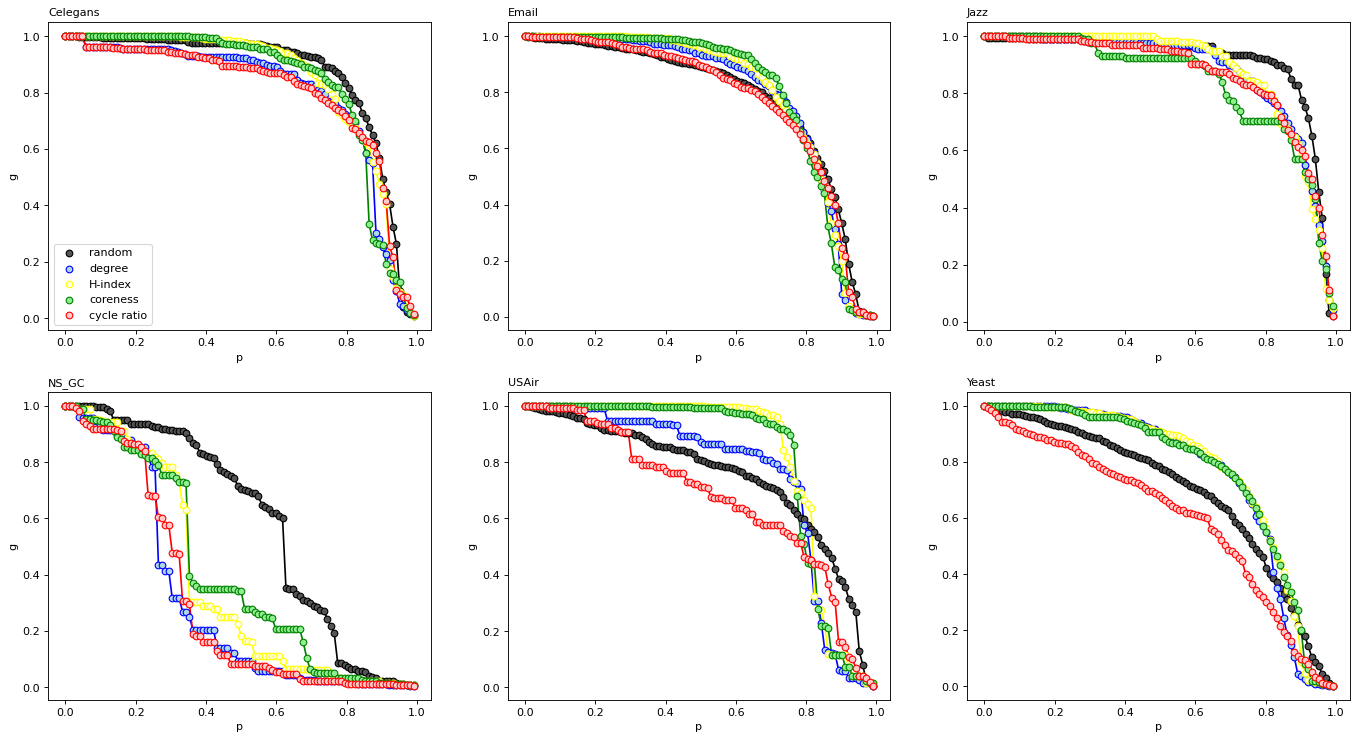

In [6]:
figure(figsize=(21, 11), dpi=80)
for index, network in enumerate(datasets):
    plt.subplot(2, 3, index+1)
    plt.title(network.split('.')[0],  fontsize=10, loc='left'), plt.xlabel('p'), plt.ylabel('g')

    network_name = network.split('.')[0]
    print(f'Processing {network_name} network')

    # Random Ratio
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = list(graph.edges())
    random.shuffle(sorted_node_ratio)
    g_random = edge_perculation(graph=graph, sorted_edges=sorted_node_ratio)
    plot_perculation(g=g_random, color='black',facecolors='#555555', label='random')
    # Cache the node ratio
    random_ratio[network_name] = sorted_node_ratio


    # Degree Ratio
    graph = read_graph(f'Dataset/{network}')
    degree_ratio_data = dict(graph.degree)
    node_ratio = edge_importance_calculator(graph=graph, node_ratio=degree_ratio_data)
    sorted_node_ratio = edge_importance_sorter(node_ratio=node_ratio, method='sum')
    g_degree = edge_perculation(graph=graph, sorted_edges=sorted_node_ratio)
    plot_perculation(g=g_degree, color='blue',facecolors='#ADD8E6', label='degree')
    # Cache the node ratio
    degree_ratio[network_name] = node_ratio

    # H-index Ratio
    graph = read_graph(f'Dataset/{network}')

    h_index_ratio_data = {}
    for node in list(graph.nodes):
        sorted_neighbor_degrees = sorted(
            (graph.degree(v) for v in graph.neighbors(node)), reverse=True)
        h = 0
        for i in range(1, len(sorted_neighbor_degrees)+1):
            if sorted_neighbor_degrees[i-1] < i:
                break
            h = i
        h_index_ratio_data[node] = h

    node_ratio = edge_importance_calculator(graph=graph, node_ratio=h_index_ratio_data)
    sorted_node_ratio = edge_importance_sorter(node_ratio=node_ratio, method='sum')
    g_hindex = edge_perculation(graph=graph, sorted_edges=sorted_node_ratio)
    plot_perculation(g=g_hindex, color='yellow',facecolors='#FFFFE0', label='H-index')
    # Cache the node ratio
    h_index_ratio[network_name] = node_ratio

    # Coreness Ratio
    graph = read_graph(f'Dataset/{network}')
    coreness_ratio_data = nx.core_number(graph)
    node_ratio = edge_importance_calculator(graph=graph, node_ratio=coreness_ratio_data)
    sorted_node_ratio = edge_importance_sorter(node_ratio=node_ratio, method='sum')
    g_coreness = edge_perculation(graph=graph, sorted_edges=sorted_node_ratio)
    plot_perculation(g=g_coreness, color='green', facecolors='#90EE90', label='coreness')
    # Cache the node ratio
    coreness_ratio[network_name] = node_ratio

    # Cycle Ratio base node
    graph = read_graph(f'Dataset/{network}')
    cr = CycleRatio(graph=graph)
    cr.prune_graph()
    cr.getSmallestCycles()
    cr.StatisticsAndCalculateIndicators(network=network_name)
    node_ratio = edge_importance_calculator(graph=graph, node_ratio=cr.CycleRatio)
    sorted_node_ratio = edge_importance_sorter(node_ratio=node_ratio, method='sum')
    g_cycle = edge_perculation(graph=graph, sorted_edges=sorted_node_ratio)
    plot_perculation(g=g_cycle, color='red',facecolors='#FFCCCC', label='cycle ratio')
    # Cache the node ratio
    cycle_ratio[network_name] = node_ratio

    indices_performance['sum'][network_name] = {
        'B': np.mean(g_random),
        'D': np.mean(g_degree),
        'H': np.mean(g_hindex),
        'C': np.mean(g_coreness),
        'R': np.mean(g_cycle),
    }
    if index == 0:
        plt.legend(loc='lower left', bbox_to_anchor=(0, 0))

<Figure size 640x480 with 0 Axes>

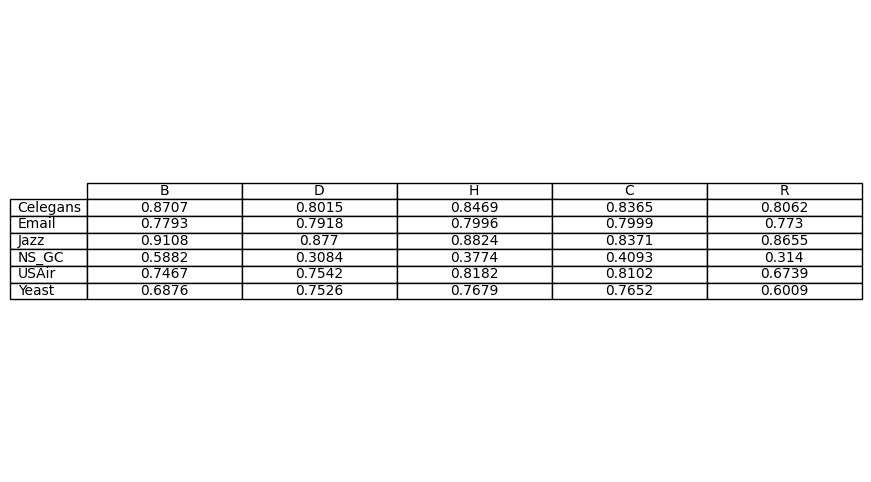

In [7]:
plt.savefig(f'edge_perculation_sum.jpg')
plt.show()

df = pd.DataFrame(indices_performance['sum']).T
for _, value in indices_performance['sum'].items():
    keys = value.keys()
    break
df.columns = list(keys)

fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(cellText=df.round(4).values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
with PdfPages('network_table.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

plt.savefig(f'edge_perculation_robustness_sum.jpg')
plt.show()

with open("edge_perculation_robustness_mul.txt", "w") as f:
    f.write(json.dumps(indices_performance, indent=4))

Processing Celegans network


100%|██████████| 2148/2148 [00:00<00:00, 4717.92it/s]


Processing Email network


100%|██████████| 5451/5451 [00:04<00:00, 1190.79it/s]


Processing Jazz network


100%|██████████| 2742/2742 [00:00<00:00, 6508.78it/s]


Processing NS_GC network


100%|██████████| 914/914 [00:00<00:00, 4978.52it/s]


Processing USAir network


100%|██████████| 2126/2126 [00:00<00:00, 4533.88it/s]


Processing Yeast network


100%|██████████| 11693/11693 [00:27<00:00, 421.32it/s]


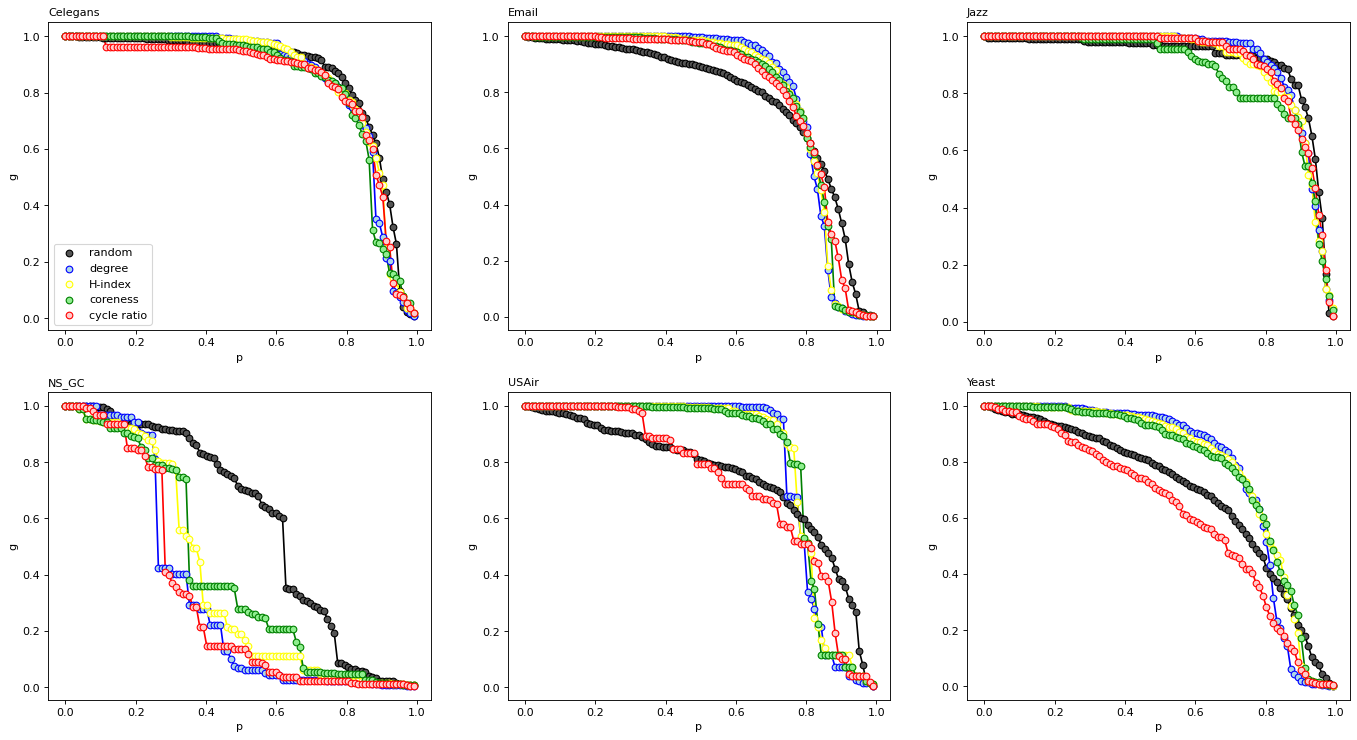

In [8]:
figure(figsize=(21, 11), dpi=80)
for index, network in enumerate(datasets):
    plt.subplot(2, 3, index+1)

    plt.title(network.split('.')[0],  fontsize=10,
                loc='left'), plt.xlabel('p'), plt.ylabel('g')

    network_name = network.split('.')[0]
    print(f'Processing {network_name} network')

    # Random Ratio
    graph = read_graph(f'Dataset/{network}')
    g_random = edge_perculation(graph=graph, sorted_edges=random_ratio[network_name])
    plot_perculation(g=g_random, color='black',facecolors='#555555', label='random')

    # Degree Ratio
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = edge_importance_sorter(node_ratio=degree_ratio[network_name], method='mul')
    g_degree = edge_perculation(graph=graph, sorted_edges=sorted_node_ratio)
    plot_perculation(g=g_degree, color='blue',facecolors='#ADD8E6', label='degree')

    # H-Index Ratio
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = edge_importance_sorter(node_ratio=h_index_ratio[network_name], method='mul')
    g_h_index = edge_perculation(graph=graph, sorted_edges=sorted_node_ratio)
    plot_perculation(g=g_h_index, color='yellow',facecolors='#FFFFE0', label='H-index')

    # Coreness Ratio
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = edge_importance_sorter(node_ratio=coreness_ratio[network_name], method='mul')
    g_coreness = edge_perculation(graph=graph, sorted_edges=sorted_node_ratio)
    plot_perculation(g=g_coreness, color='green', facecolors='#90EE90', label='coreness')

    # Cycle Ratio base node
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = edge_importance_sorter(node_ratio=cycle_ratio[network_name], method='mul')
    g_cycle = edge_perculation(graph=graph, sorted_edges=sorted_node_ratio)
    plot_perculation(g=g_cycle, color='red',facecolors='#FFCCCC', label='cycle ratio')

    indices_performance['mul'][network_name] = {
        'B': np.mean(g_random),
        'D': np.mean(g_degree),
        'H': np.mean(g_hindex),
        'C': np.mean(g_coreness),
        'R': np.mean(g_cycle),
    }
    if index == 0:
        plt.legend(loc='lower left', bbox_to_anchor=(0, 0))

<Figure size 640x480 with 0 Axes>

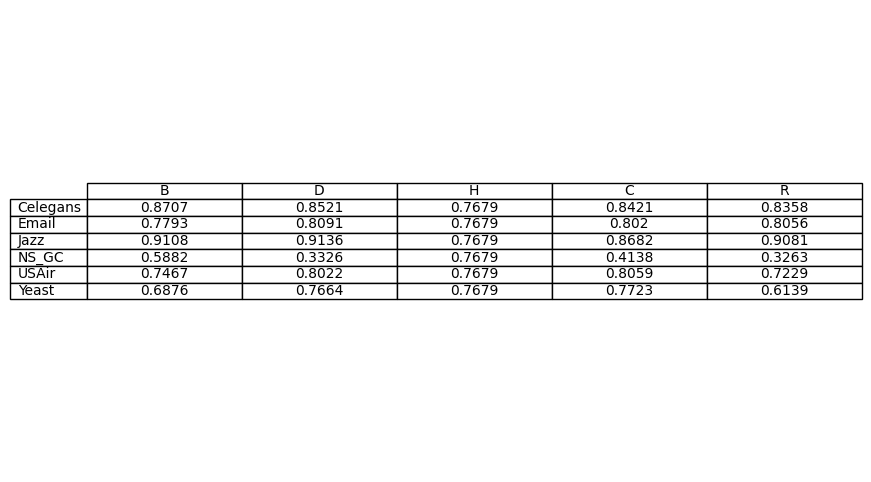

In [9]:
plt.savefig(f'edge_perculation_mul.jpg')
plt.show()

df = pd.DataFrame(indices_performance['mul']).T
for _, value in indices_performance['mul'].items():
    keys = value.keys()
    break
df.columns = list(keys)

fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(cellText=df.round(4).values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
with PdfPages('network_table.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

plt.savefig(f'edge_perculation_robustness_mul.jpg')
plt.show()

with open("edge_perculation_robustness_mul.txt", "w") as f:
    f.write(json.dumps(indices_performance, indent=4))
